In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# 设置全局字体
matplotlib.rcParams["font.family"] = "SimSun"


# def ts_profiling(df: pd.DataFrame, output_file: str = "profiling_report.html") -> None:
#     profile = ydata_profiling.ProfileReport(df, tsmode=True)
#     profile.to_file(output_file)


raw_data = pd.read_csv(r"data\qiyeshuju-4S间隔.csv", encoding="gbk")
raw_data.index = pd.to_datetime(raw_data["时间"])
raw_data.drop("时间", axis=1, inplace=True)

columns = raw_data.columns
print(columns)

Index(['右侧换火信号', 'CEMS出口烟尘($mg/m^{3}$)', 'CEMS出口一氧化氮($mg/m^{3}$)',
       'VA.SO2($mg/m^{3}$)', 'VA.NOX($mg/m^{3}$)', 'CEMS出口含氧(%)', 'VA.O2(%)',
       'NOX转换值($mg/m^{3}$)', '氨水泵B频率反馈(Hz)', '1#线氨水流量(L/h)', 'C泵频率反馈(Hz)',
       '反应塔入口温度', '1#线氨水调节阀(L/h)', '反应塔出口温度', 'CCF出口温度', '氨水分段设定反馈($m^{3}/h$)',
       'CCF6温度', 'CCF5温度', 'CCF4温度', 'CCF3温度', 'CCF2温度', '出口CEMS温度', 'CCF1温度',
       'CCF7温度', '喷氨压缩空气压力', 'CCF1差压', 'CCF2差压', 'CCF3差压', 'CCF4差压', 'CCF5差压',
       '反应塔差压', 'CCF6差压', 'B变频器电流(A)', 'A变频器电流(A)', 'B输出频率(Hz)',
       '氨逃逸小时均值($mg/m^{3}$)', 'A输出频率(Hz)', 'CCF7差压', '烟气量($Nm^{3}/h$)',
       'CCF出口压力', 'CEMS出口流量(m/s)', '22出口CEMS温度', '22CEMS出口烟尘($mg/m^{3}$)',
       '出口CEMS湿度(%)', '22烟气量($Nm^{3}/h$)', '右侧换火信号-数值'],
      dtype='object')


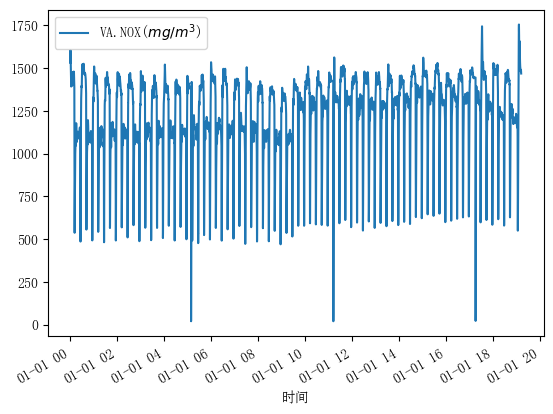

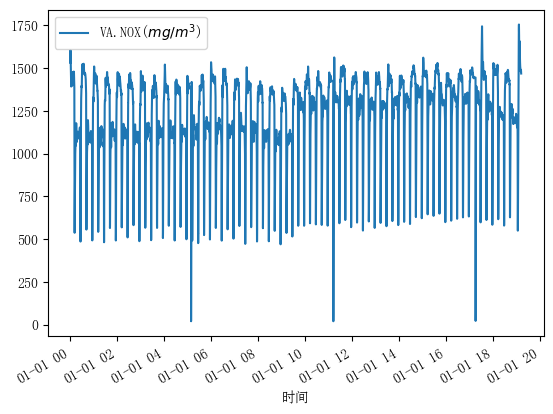

In [2]:
one_data = raw_data["2024-01-01 00:00:00":"2024-01-01 23:59:59"]
train_data = one_data[[r"VA.NOX($mg/m^{3}$)"]].iloc[:int(len(one_data)*0.8)] # 训练数据
test_data = one_data[[r"VA.NOX($mg/m^{3}$)"]].iloc[int(len(one_data)*0.8):] # 测试数据

train_data.plot()
train_data.plot()
one_data.to_csv(r"data\one_data.csv")
one_data[[r"VA.NOX($mg/m^{3}$)"]].to_csv(r"data\nox_onde_day.csv")

In [ ]:
# 导入 pytorch 库
import torch
import torch.nn as nn

# 定义 LSTM 模型的类
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        # 设置模型的参数
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        # 定义 LSTM 层
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # 定义输出层
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # 初始化隐藏状态和细胞状态
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # 通过 LSTM 层得到输出和最终的隐藏状态和细胞状态
        out, (hn, cn) = self.lstm(x, (h0, c0))
        # 只取最后一个时间步的输出
        out = out[:, -1, :]
        # 通过输出层得到最终的预测
        out = self.fc(out)
        return out

# 定义模型的超参数
input_size = 1 # 输入特征的维度
hidden_size = 32 # 隐藏层的大小
num_layers = 2 # LSTM 层的个数
output_size = 1 # 输出特征的维度
learning_rate = 0.01 # 学习率
num_epochs = 100 # 训练的轮数
window_size = 10 # 窗口大小，用于将时序数据转换为监督学习数据

# 创建模型的实例
model = LSTM(input_size, hidden_size, num_layers, output_size)

# 定义损失函数，这里使用均方误差
criterion = nn.MSELoss()

# 定义优化器，这里使用随机梯度下降
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# 将 pandas 数据框转换为 numpy 数组
train_data = train_df.values
test_data = test_df.values

# 定义一个函数，用于将时序数据转换为监督学习数据
def create_dataset(data, window_size):
    x = [] # 存储输入数据
    y = [] # 存储输出数据
    for i in range(len(data) - window_size):
        # 用连续的 window_size 个数据作为输入
        x.append(data[i:i+window_size])
        # 用下一个数据作为输出
        y.append(data[i+window_size])
    # 将列表转换为 numpy 数组
    x = np.array(x)
    y = np.array(y)
    # 将 numpy 数组转换为 pytorch 张量
    x = torch.from_numpy(x).float()
    y = torch.from_numpy(y).float()
    return x, y

# 使用窗口大小为 10，将训练数据和测试数据转换为监督学习数据
x_train, y_train = create_dataset(train_data, window_size)
x_test, y_test = create_dataset(test_data, window_size)

# 训练模型
for epoch in range(num_epochs):
    # 将输入数据和输出数据传入模型，得到预测
    y_pred = model(x_train)
    # 计算损失
    loss = criterion(y_pred, y_train)
    # 清空梯度
    optimizer.zero_grad()
    # 反向传播
    loss.backward()
    # 更新参数
    optimizer.step()
    # 打印每轮的损失
    print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')

# 测试模型
# 将模型设为评估模式
model.eval()
# 用测试数据进行预测
y_pred = model(x_test)
# 计算测试损失
test_loss = criterion(y_pred, y_test)
# 打印测试损失
print(f'Test Loss: {test_loss.item():.4f}')
